# **Facial Emotion Detection**

## **Problem Definition**

**The context:** Why is this problem important to solve?<br>
**The objectives:** What is the intended goal?<br>
**The key questions:** What are the key questions that need to be answered?<br>
**The problem formulation:** What are we trying to solve using data science?



## **About the dataset**

The data set consists of 3 folders, i.e., 'test', 'train', and 'validation'.
Each of these folders has four subfolders:

**‘happy’**: Images of people who have happy facial expressions.<br>
**‘sad’**: Images of people with sad or upset facial expressions.<br>
**‘surprise’**: Images of people who have shocked or surprised facial expressions.<br>
**‘neutral’**: Images of people showing no prominent emotion in their facial expression at all.<br>


**Facial emotion detection is a complex subject—both socially and medically.
A misclassification can lead to serious consequences, particularly in sensitive contexts such as with children on the autism spectrum.**

**The challenge lies not only in the quality of source images and the extraction of relevant features, but also in managing noise and accounting for the nuances of human interpretation.**


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Importing the Libraries**

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import os
import zipfile

import cv2
import seaborn as sns

import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, BatchNormalization, Activation, Input, LeakyReLU, Dropout, Flatten
from tensorflow.keras import backend
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import losses, optimizers
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from google.colab.patches import cv2_imshow
import warnings
warnings.filterwarnings('ignore')

### **Let us load and unzip the data**

**Note:**
- You must download the dataset from the link provided on Olympus and upload the same on your Google drive before executing the code in the next cell.
- In case of any error, please make sure that the path of the file is correct as the path may be different for you.

**Original Images:**

48 x 48, 8-bit = 256 Shade Variations of Each Color .jpg, 96 dpi (density/pixel)

A commonly used size for face recognition tasks is 224x224 or 128x128 for moderate to high resolution images. Here we'll focus on efficiency.

In [4]:
path_zip = '/content/drive/MyDrive/Facial_emotion_images.zip'

In [5]:
with zipfile.ZipFile(path_zip, 'r') as zip_ref:
  zip_ref.extractall()

1. Path

In [6]:
parent_dir = '/content/Facial_emotion_images'

train = '/content/Facial_emotion_images/train'
test = '/content/Facial_emotion_images/test'
val = '/content/Facial_emotion_images/validation'

In [7]:
#or:
parent_dir = '/content/Facial_emotion_images'

train = os.path.join(parent_dir, 'train')
val = os.path.join(parent_dir, 'validation')
test = os.path.join(parent_dir, 'test')

train_h = os.path.join(train, 'happy')
train_n = os.path.join(train, 'neutral')
train_sa = os.path.join(train, 'sad')
train_su = os.path.join(train, 'surprise')

val_h = os.path.join(val, 'happy')
val_n = os.path.join(val, 'neutral')
val_sa = os.path.join(val, 'sad')
val_su = os.path.join(val, 'surprise')

2. Image Parameters

In [8]:
img_h, img_w = 48, 48
batches_size = 32

3. Data Preprocessing w/ ImageDataGenerator : NN Flatten into 1D array - CNN 2D/3D tensors (h,w,c)

In [9]:
train_data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

basic_data_gen = ImageDataGenerator(rescale=1./255)
class_names = ['happy', 'neutral', 'sad', 'surprise']

# Training generator with augmentation
train_generator = train_data_gen.flow_from_directory(
    train,  # Path to 'train' folder
    target_size=(img_h, img_w),
    batch_size=batches_size,
    class_mode='categorical',
    shuffle=True,
)

# Validation (no augmentation)
val_generator = basic_data_gen.flow_from_directory(
    val,  # Path to 'validation' folder
    target_size=(img_h, img_w),
    batch_size=batches_size,
    class_mode='categorical',
    shuffle=False,
)

# Test (no aug)
test_generator = basic_data_gen.flow_from_directory(
    test,
    target_size=(img_h, img_w),
    batch_size=batches_size,
    class_mode='categorical',
    shuffle=False,
)

num_classes = len(train_generator.class_indices)
print(f"Number of classes detected: {num_classes}")

num_classes = 4

Found 15109 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.
Found 128 images belonging to 4 classes.
Number of classes detected: 4


Manual preprocessing

In [10]:
def load_and_preprocess_images(data_dir, img_size=(48, 48)):
  images = []
  labels = []
  categories = ['happy', 'neutral', 'sad', 'surprise']

  for category in categories:
    path = os.path.join(data_dir, category)
    class_num = categories.index(category)  # Get the numerical label for the category

    for img in os.listdir(path):
      img_array = cv2.imread(os.path.join(path, img))
      img_resize = cv2.resize(img_array, img_size)
      images.append(img_resize)
      labels.append(class_num)

  return np.array(images), np.array(labels)

# Load and preprocess training and test data
train ,  y_train = load_and_preprocess_images('/content/Facial_emotion_images/train')
val , y_val  = load_and_preprocess_images('/content/Facial_emotion_images/validation')
test , y_test = load_and_preprocess_images('/content/Facial_emotion_images/test')

print(len(train), len(val), len(test), train.shape, val.shape, test.shape)
print(len(y_train), len(y_val), len(y_test), y_train.shape, y_val.shape, y_test.shape)


15109 4977 128 (15109, 48, 48, 3) (4977, 48, 48, 3) (128, 48, 48, 3)
15109 4977 128 (15109,) (4977,) (128,)


Total= 20,214   ||       75% = 15,160

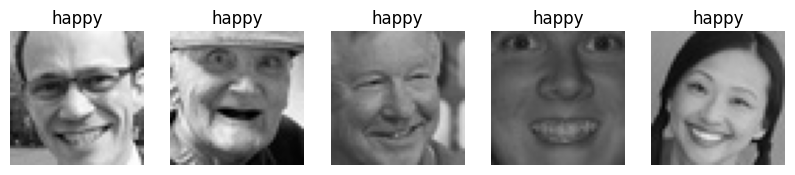

Category 0: 3976 images
Category 1: 3978 images
Category 2: 3982 images
Category 3: 3173 images


In [11]:
def display_sample_images(images, labels, categories, num_samples=5):
    plt.figure(figsize=(10, 5))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
        plt.title(categories[labels[i]])
        plt.axis('off')
    plt.show()

display_sample_images(train, y_train, ['happy', 'neutral', 'sad', 'surprise'], num_samples=5)

def check_label_distribution(labels):
    unique, counts = np.unique(labels, return_counts=True)
    label_distribution = dict(zip(unique, counts))
    for category, count in label_distribution.items():
        print(f"Category {category}: {count} images")

# Check label distrib
check_label_distribution(y_train)

Category 0: 3976 images (Happy)

Category 1: 3978 images (Neutral)

Category 2: 3982 images (Sad)

Category 3: 3173 images (Surprise)

## **Visualizing our Classes**

Let's look at our classes.

### **Happy**

**Observations and Insights:**

**Smile Detection**

Lines_curves extending from the corners.

Desired shape: Concave upward curve (U-shape).

Color Intensity: Detect white regions (e.g., teeth) with pixel intensity values near 255 in the mouth area.

Focus Area: Prioritize analysis on the lower face region for accurate mouth shape and expression cues.

Consistent and distinct: Easy to detect


---



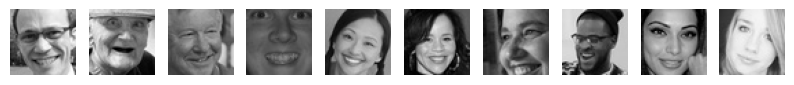

Number of 'happy' images: 3976


In [12]:
train_h = '/content/Facial_emotion_images/train/happy'

plt.figure(figsize=(10, 1))

for i in range(10):

    image_files = os.listdir(train_h)
    image_path = os.path.join(train_h, image_files[i])

    img = cv2.imread(image_path)
    plt.subplot(1, 10, i+1)

    plt.imshow(img, cmap="gray")
    plt.axis('off')

plt.show()

print(f"Number of 'happy' images: {len(image_files)}")

### **Sad**

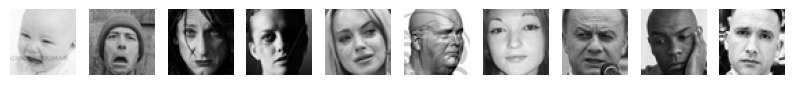

Number of 'sad' images: 3982


In [13]:
train_sa = '/content/Facial_emotion_images/train/sad'


plt.figure(figsize=(10, 1))

for i in range(10):

    image_files = os.listdir(train_sa)
    image_path = os.path.join(train_sa, image_files[i])

    img = cv2.imread(image_path)
    plt.subplot(1, 10, i+1)

    plt.imshow(img, cmap="gray")
    plt.axis('off')

plt.show()

print(f"Number of 'sad' images: {len(image_files)}")

**Observations and Insights:**

**Sad Detection**

Look for downward mouth curves—shaped like a convex 'n'.

Desired shape: Convex downward curve (n-shape).

Color Intensity: Darker regions around the mouth.

Focus Area: Upper face, particularly the eyebrows, for additional emotional cues.

### **Neutral**

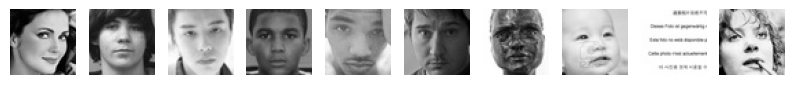

Number of 'neutral' images: 3978


In [14]:
train_n = '/content/Facial_emotion_images/train/neutral'


plt.figure(figsize=(10, 1))

for i in range(10):

    image_files = os.listdir(train_n)
    image_path = os.path.join(train_n, image_files[i])

    img = cv2.imread(image_path)
    plt.subplot(1, 10, i+1)

    plt.imshow(img, cmap="gray")
    plt.axis('off')

plt.show()

print(f"Number of 'neutral' images: {len(image_files)}")

**Observations and Insights:**

**Neutral Detection**

Look for a neutral mouth—straight or slightly flat, with no pronounced curves.

Desired shape: No significant curvature (flat or slightly horizontal).

Color Intensity: Neutral.

Focus Area: Entire face, with particular attention to the balance between the mouth and eyes.

Neither happy, nor sad

### **Surprised**

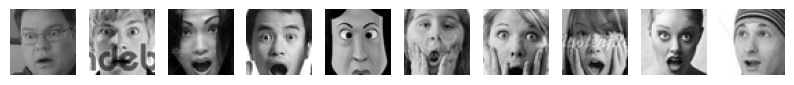

Number of 'surprised' images: 3173


In [15]:
train_su = '/content/Facial_emotion_images/train/surprise'

plt.figure(figsize=(10, 1))

for i in range(10):

    image_files = os.listdir(train_su)
    image_path = os.path.join(train_su, image_files[i])

    img = cv2.imread(image_path)
    plt.subplot(1, 10, i+1)

    plt.imshow(img, cmap="gray")
    plt.axis('off')

plt.show()

print(f"Number of 'surprised' images: {len(image_files)}")

**Observations and Insights:**

**Surprise Detection**

Look for a wide, open mouth, often forming an oval shape.

Desired shape: Open mouth, no clear curve, with the corners pulled slightly downward.

Color Intensity: Light intensity around the mouth area, with an emphasis on the contrast between the lips and teeth.

Focus Area: Upper face, especially the eyebrows and eyes, which should appear wide open and raised.

## **Checking Distribution of Classes**

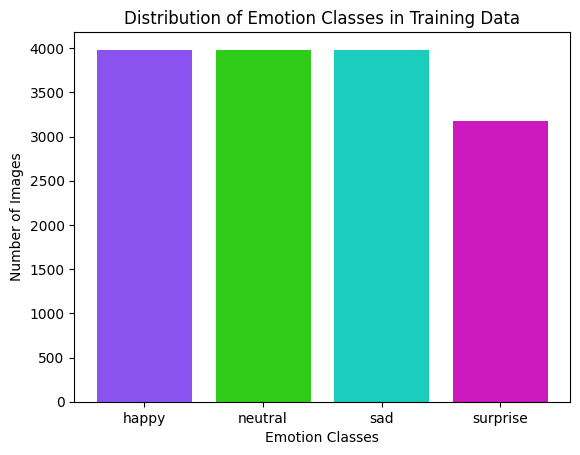

In [16]:
# Count the occurrences of each class
unique, counts = np.unique(y_train, return_counts=True)
class_counts = dict(zip(unique, counts))

categories = ['happy', 'neutral', 'sad', 'surprise']

plt.bar(categories, counts, color=['#8a53f0', '#2fcd1a', '#1acdbd', '#cd1abf'])
plt.xlabel('Emotion Classes')
plt.ylabel('Number of Images')
plt.title('Distribution of Emotion Classes in Training Data')
plt.show()

**Observations and Insights:**

The Total is 15109 pictures and the mean 3777.25.

-604.25 pictures miss to the total picture count.

(3173-3777.25)² / 4 = 91 images far from the mean of the dataset.

Class imbalance can lead to biased models that perform well on majority classes while poorly on minority classes.

## **Creating our Data Loaders**

In this section, we are creating data loaders that we will use as inputs to our Neural Network.

Two options for the color_mode.

Color_mode = 'rgb' or color_mode = 'grayscale'. We will need to try out both and see which one gives better performance.

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data loader for RGB images
rgb_datagen = ImageDataGenerator(rescale=1.0/255)
rgb_loader = rgb_datagen.flow_from_directory(
    '/content/Facial_emotion_images/train',
    target_size=(48, 48),
    color_mode='rgb',
    class_mode='categorical'
)

# Data loader for Grayscale images
grayscale_datagen = ImageDataGenerator(rescale=1.0/255)
grayscale_loader = grayscale_datagen.flow_from_directory(
    '/content/Facial_emotion_images/train',
    target_size=(48, 48),
    color_mode='grayscale',
    class_mode='categorical'
)

Found 15109 images belonging to 4 classes.
Found 15109 images belonging to 4 classes.


The RGB values are transformed into grayscale using the NTSC formula: 0.299 × Red + 0.587 × Green + 0.114 × Blue.

This formula is designed to approximate the average human perception of the brightness of red, green, and blue light.

Since we are here in black and gray, the problem does not arise.

But we have three layers of identical values.

In [ ]:
print("Shape:", y_train[0].shape)
print()
print("First image:\n", y_train[0])

Shape: ()

First image:
 0


## **Model Building**

Advantages of CNNs over ANNs and are they applicable here?

**A CNN model is better for extracting features, plus, it allows to implement a hierarchical "slide" that might be useful for locations like smile, eyebrows...**


### **Creating the Base Neural Network**

In [20]:
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

1/ Define NN Model

In [ ]:
nn_model = models.Sequential([
    Flatten(input_shape=(48, 48, 3)),
    tf.keras.layers.Dense(256, activation='relu', input_shape=(1024, )),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(rate = 0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(4, activation = 'softmax')
])

adam = optimizers.Adam(learning_rate=0.0005)

nn_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 6912)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │     1,769,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,002,052 (7.64 MB)

 Trainable params: 2,001,540 (7.64 MB)

 Non-trainable params: 512 (2.00 KB)

2/ Compile Model

In [ ]:
nn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

3/ Train Model

In [ ]:
nn_history = nn_model.fit(train_generator, epochs=20, validation_data=val_generator, verbose=2)

Epoch 1/20
473/473 - 38s - 80ms/step - accuracy: 0.3004 - loss: 1.4143 - val_accuracy: 0.3749 - val_loss: 1.6241
Epoch 2/20
473/473 - 34s - 72ms/step - accuracy: 0.3298 - loss: 1.3558 - val_accuracy: 0.2976 - val_loss: 1.3545
Epoch 3/20
473/473 - 35s - 75ms/step - accuracy: 0.3577 - loss: 1.3267 - val_accuracy: 0.2497 - val_loss: 1.4754
Epoch 4/20
473/473 - 34s - 71ms/step - accuracy: 0.3696 - loss: 1.3144 - val_accuracy: 0.4688 - val_loss: 1.1981
Epoch 5/20
473/473 - 36s - 76ms/step - accuracy: 0.3779 - loss: 1.3068 - val_accuracy: 0.3361 - val_loss: 1.3593
Epoch 6/20
473/473 - 33s - 70ms/step - accuracy: 0.3802 - loss: 1.3045 - val_accuracy: 0.2795 - val_loss: 1.4180
Epoch 7/20
473/473 - 36s - 77ms/step - accuracy: 0.3806 - loss: 1.3003 - val_accuracy: 0.3978 - val_loss: 1.2549
Epoch 8/20
473/473 - 34s - 71ms/step - accuracy: 0.3953 - loss: 1.2923 - val_accuracy: 0.4840 - val_loss: 1.1954
Epoch 9/20
473/473 - 35s - 75ms/step - accuracy: 0.3906 - loss: 1.2878 - val_accuracy: 0.3814 - 

Around 42% accuracy on the training set vs 46% on the validation set.

Not good.

Callbacks

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

callbacks = [
    ModelCheckpoint('best_model.keras',  # Using .keras extension
                    monitor='val_loss',
                    save_best_only=True,
                    mode='min',
                    verbose=1),

    EarlyStopping(monitor='val_loss',
                  patience=3,
                  restore_best_weights=True,
                  verbose=1),

    ReduceLROnPlateau(monitor='val_loss',
                      factor=0.5,
                      patience=2,
                      verbose=2)
]

nn_history = nn_model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    verbose=2,
    callbacks=callbacks,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=val_generator.samples // val_generator.batch_size
)

nn_model.save('final_model.keras')

from tensorflow.keras.models import load_model

best_model = load_model('best_model.keras')

Epoch 1/20

Epoch 1: val_loss improved from inf to 1.18719, saving model to best_model.keras
472/472 - 38s - 80ms/step - accuracy: 0.4122 - loss: 1.2687 - val_accuracy: 0.4728 - val_loss: 1.1872 - learning_rate: 1.2500e-04
Epoch 2/20

Epoch 2: val_loss improved from 1.18719 to 1.18367, saving model to best_model.keras
472/472 - 4s - 8ms/step - accuracy: 0.5625 - loss: 1.2193 - val_accuracy: 0.4780 - val_loss: 1.1837 - learning_rate: 1.2500e-04
Epoch 3/20

Epoch 3: val_loss improved from 1.18367 to 1.17939, saving model to best_model.keras
472/472 - 81s - 171ms/step - accuracy: 0.4102 - loss: 1.2619 - val_accuracy: 0.4754 - val_loss: 1.1794 - learning_rate: 1.2500e-04
Epoch 4/20

Epoch 4: val_loss did not improve from 1.17939
472/472 - 2s - 5ms/step - accuracy: 0.3438 - loss: 1.3005 - val_accuracy: 0.4722 - val_loss: 1.1826 - learning_rate: 1.2500e-04
Epoch 5/20

Epoch 5: val_loss did not improve from 1.17939

Epoch 5: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
47

4/ Evaluate on Test Set

In [ ]:
loss_value, accuracy_value = nn_model.evaluate(test_generator)
print(f"NN Test Accuracy: {accuracy_value: .4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5396 - loss: 1.1196
NN Test Accuracy:  0.4922


5/ Plot Training-Validation Accuracy and loss

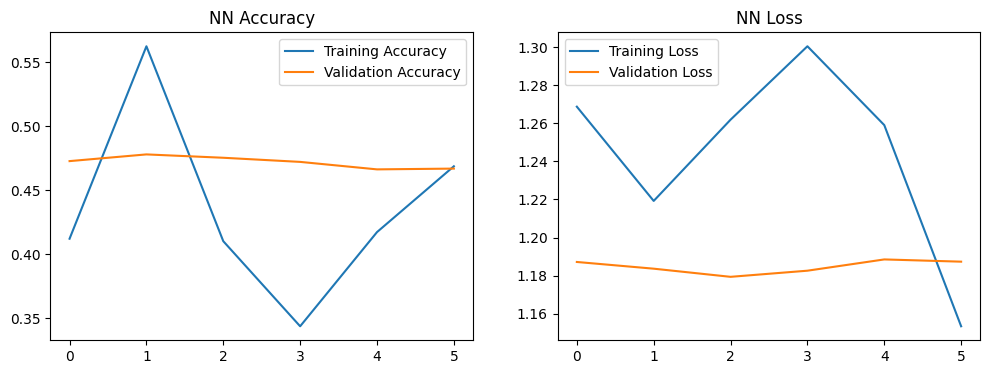

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(nn_history.history['accuracy'], label='Training Accuracy')
plt.plot(nn_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('NN Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(nn_history.history['loss'], label='Training Loss')
plt.plot(nn_history.history['val_loss'], label='Validation Loss')
plt.title('NN Loss')
plt.legend()
plt.show()

### **Compiling and Training the Model**

### **Evaluating the Model on the Test Set**

In [ ]:
test_loss, test_accuracy = nn_model.evaluate(test_generator,steps=test_generator.samples // test_generator.batch_size, verbose=2)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

4/4 - 0s - 23ms/step - accuracy: 0.4922 - loss: 1.2118
Test Loss: 1.2118
Test Accuracy: 0.4922


**Observations and Insights:**


**Both the input size and data preprocessing (normalization) are critical factors in the performance of the models.**

**Overall, the model performs poorly, being unstable, it is prone to overfitting.**

### **Creating the second Convolutional Neural Network**

- Try out a slightly larger architecture

1/ Define a basic CNN

In [ ]:
cnn_model = models.Sequential([
    tf.keras.layers.Input(shape=(48, 48, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')
])

cnn_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,144,388 (4.37 MB)

 Trainable params: 1,144,388 (4.37 MB)

 Non-trainable params: 0 (0.00 B)

2/ Compile CNN

In [ ]:
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

3/ Train CNN

In [ ]:
cnn_history = cnn_model.fit(train_generator, epochs=20, validation_data = val_generator, verbose=2)

Epoch 1/20
473/473 - 87s - 185ms/step - accuracy: 0.3487 - loss: 1.3107 - val_accuracy: 0.4593 - val_loss: 1.1945
Epoch 2/20
473/473 - 79s - 167ms/step - accuracy: 0.4588 - loss: 1.1740 - val_accuracy: 0.5777 - val_loss: 1.0110
Epoch 3/20
473/473 - 80s - 170ms/step - accuracy: 0.5370 - loss: 1.0510 - val_accuracy: 0.6283 - val_loss: 0.8838
Epoch 4/20
473/473 - 78s - 166ms/step - accuracy: 0.5828 - loss: 0.9716 - val_accuracy: 0.6580 - val_loss: 0.8376
Epoch 5/20
473/473 - 83s - 176ms/step - accuracy: 0.6162 - loss: 0.9189 - val_accuracy: 0.6805 - val_loss: 0.7888
Epoch 6/20
473/473 - 79s - 166ms/step - accuracy: 0.6245 - loss: 0.8876 - val_accuracy: 0.6488 - val_loss: 0.8702
Epoch 7/20
473/473 - 80s - 170ms/step - accuracy: 0.6402 - loss: 0.8573 - val_accuracy: 0.6841 - val_loss: 0.7795
Epoch 8/20
473/473 - 79s - 166ms/step - accuracy: 0.6488 - loss: 0.8407 - val_accuracy: 0.7004 - val_loss: 0.7416
Epoch 9/20
473/473 - 79s - 166ms/step - accuracy: 0.6527 - loss: 0.8310 - val_accuracy: 

4/ Evaluate on Test Set

In [ ]:
cnn_loss, cnn_accuracy = cnn_model.evaluate(test_generator)
print(f"CNN Test Accuracy: {cnn_accuracy: .4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7323 - loss: 0.5488
CNN Test Accuracy:  0.7188


5/ Training-Validation Accuracy & Loss

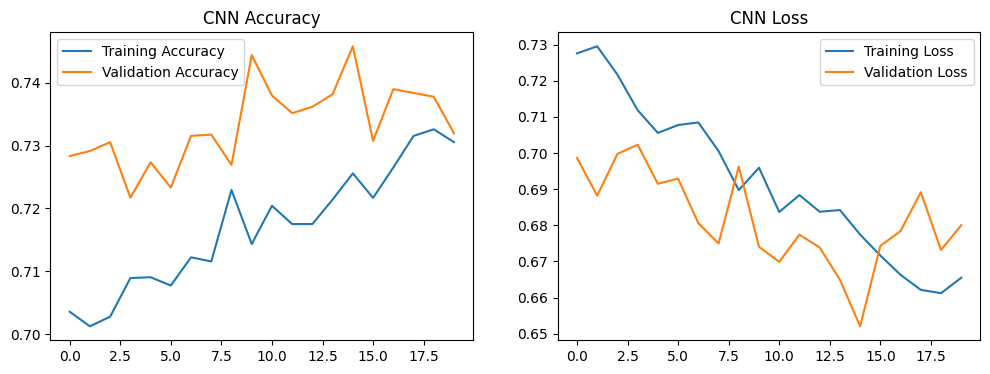

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['accuracy'], label='Training Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['loss'], label='Training Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.title('CNN Loss')
plt.legend()
plt.show()

### **Compiling and Training the Model**

In [ ]:
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
cnn_history = cnn_model.fit(train_generator, epochs=20, validation_data = val_generator)

Epoch 1/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 87s 180ms/step - accuracy: 0.7104 - loss: 0.7171 - val_accuracy: 0.7284 - val_loss: 0.6987
Epoch 2/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 80s 170ms/step - accuracy: 0.7008 - loss: 0.7269 - val_accuracy: 0.7292 - val_loss: 0.6882
Epoch 3/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 85s 179ms/step - accuracy: 0.7018 - loss: 0.7212 - val_accuracy: 0.7306 - val_loss: 0.6997
Epoch 4/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 82s 173ms/step - accuracy: 0.7057 - loss: 0.7132 - val_accuracy: 0.7217 - val_loss: 0.7023
Epoch 5/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 81s 171ms/step - accuracy: 0.7068 - loss: 0.7031 - val_accuracy: 0.7273 - val_loss: 0.6915
Epoch 6/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 85s 180ms/step - accuracy: 0.7055 - loss: 0.7125 - val_accuracy: 0.7233 - val_loss: 0.6929
Epoch 7/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 138s 170ms/step - accuracy: 0.7097 - loss: 0.7180 - val_accuracy: 0.7316 - val_loss: 0.6806
Epoch 8/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 82s 174ms/step - accuracy: 0.7129 - loss: 

### **Evaluating the Model on the Test Set**

In [ ]:
cnn_loss, cnn_accuracy = cnn_model.evaluate(test_generator)
print(f"CNN Test Accuracy: {cnn_accuracy: .4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.7052 - loss: 0.6365
CNN Test Accuracy:  0.6953


**ANOTHER CNN**

In [ ]:
img_h, img_w = 48, 48
batches_size = 32

In [ ]:
cnn_model_2 = Sequential()

cnn_model_2.add(Conv2D(32, (3, 3), input_shape=(img_h, img_w, 3), padding='same'))
cnn_model_2.add(LeakyReLU(0.1))
cnn_model_2.add(MaxPooling2D(2, 2))

cnn_model_2.add(Conv2D(64, (3, 3), padding = 'same'))
cnn_model_2.add(LeakyReLU(0.1))
cnn_model_2.add(MaxPooling2D(2, 2))

cnn_model_2.add(Conv2D(128, (3, 3), padding = 'same'))
cnn_model_2.add(LeakyReLU(0.1))
cnn_model_2.add(MaxPooling2D(2,2))

cnn_model_2.add(Conv2D(256, (3, 3), padding = 'same'))
cnn_model_2.add(LeakyReLU(0.1))
cnn_model_2.add(MaxPooling2D(2, 2))

cnn_model_2.add(Flatten())
cnn_model_2.add(Dense(512))
cnn_model_2.add(LeakyReLU(0.1))

cnn_model_2.add(Dense(4, activation = 'softmax'))

adam = optimizers.Adam(learning_rate = 0.001)

cnn_model_2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 48, 48, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 6, 6, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 512)            │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,570,628 (5.99 MB)

 Trainable params: 1,570,628 (5.99 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cnn_model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
cnn_history_2 = cnn_model_2.fit(train_generator, epochs=20, validation_data = val_generator, verbose=2)

Epoch 1/20
473/473 - 140s - 296ms/step - accuracy: 0.3365 - loss: 1.3265 - val_accuracy: 0.4752 - val_loss: 1.1809
Epoch 2/20
473/473 - 137s - 290ms/step - accuracy: 0.4725 - loss: 1.1611 - val_accuracy: 0.5622 - val_loss: 1.0468
Epoch 3/20
473/473 - 137s - 290ms/step - accuracy: 0.5679 - loss: 1.0021 - val_accuracy: 0.6323 - val_loss: 0.8855
Epoch 4/20
473/473 - 136s - 287ms/step - accuracy: 0.6115 - loss: 0.9101 - val_accuracy: 0.6673 - val_loss: 0.8385
Epoch 5/20
473/473 - 148s - 312ms/step - accuracy: 0.6391 - loss: 0.8553 - val_accuracy: 0.6958 - val_loss: 0.7562
Epoch 6/20
473/473 - 190s - 402ms/step - accuracy: 0.6542 - loss: 0.8259 - val_accuracy: 0.6755 - val_loss: 0.8169
Epoch 7/20
473/473 - 138s - 292ms/step - accuracy: 0.6656 - loss: 0.7996 - val_accuracy: 0.6474 - val_loss: 0.8750
Epoch 8/20
473/473 - 140s - 297ms/step - accuracy: 0.6773 - loss: 0.7711 - val_accuracy: 0.7123 - val_loss: 0.7119
Epoch 9/20
473/473 - 139s - 295ms/step - accuracy: 0.6822 - loss: 0.7566 - val_a

In [ ]:
cnn_model_2.evaluate(val_generator)

156/156 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - accuracy: 0.7785 - loss: 0.5819


[0.6887319087982178, 0.7337753772735596]

In [ ]:
loss, accuracy = cnn_model_2.evaluate(test_generator, verbose=2)
print(f"CNN Test Accuracy: {accuracy: .4f}")

4/4 - 0s - 68ms/step - accuracy: 0.6797 - loss: 0.7054
CNN Test Accuracy:  0.6797


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


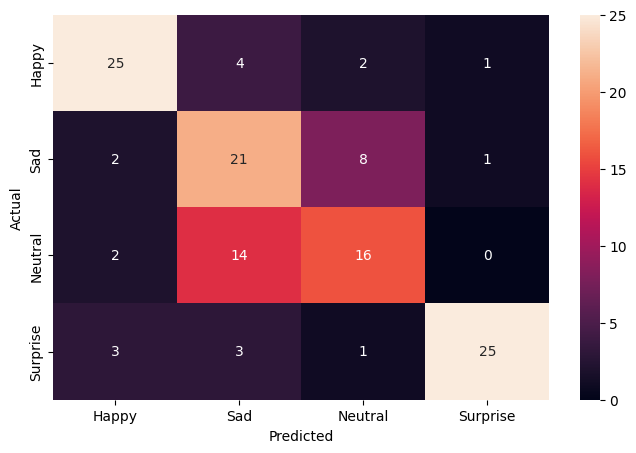

              precision    recall  f1-score   support

       Happy       0.78      0.78      0.78        32
         Sad       0.50      0.66      0.57        32
     Neutral       0.59      0.50      0.54        32
    Surprise       0.93      0.78      0.85        32

    accuracy                           0.68       128
   macro avg       0.70      0.68      0.68       128
weighted avg       0.70      0.68      0.68       128



In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred = cnn_model_2.predict(test_generator) #Generates predicted probabilities for each class.
pred = np.argmax(pred, axis = 1) #Converts the probabilities into predicted class labels

y_true = test_generator.classes

cm = confusion_matrix(y_true, pred)
plt.figure(figsize = (8, 5))
sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['Happy', 'Sad', 'Neutral', 'Surprise'], yticklabels = ['Happy', 'Sad', 'Neutral', 'Surprise'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

from sklearn.metrics import classification_report

print(classification_report(y_true, pred, target_names=['Happy', 'Sad', 'Neutral', 'Surprise']))

**Observations and Insights:**

**128 images in the dataset test = 32 for each class.**
**4 classes × 32 images = 128 test samples.**

**75% accuracy on the  training set and 73 in validation.**
**The best result achieved so far.**

**78% on the test dataset.**

**Black-and-white images, grayscale mode is the better choice for performance, as it reduces dimensionality, computational complexity, and avoids the unnecessary use of additional channels.**

## **Transfer Learning Architectures**

In this section, we will create several Transfer Learning architectures. For the pre-trained models, we will select three popular architectures namely, **VGG16, ResNet v2, and Efficient Net**. The difference between these architectures and the previous architectures is that these will require 3 input channels while the earlier ones worked on 'grayscale' images. Therefore, we need to create new DataLoaders.

### **Creating our Data Loaders for Transfer Learning Architectures**

In this section, we are creating data loaders that we will use as inputs to our Neural Network. We will have to go with color_mode = 'rgb' as this is the required format for the transfer learning architectures.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.models import Sequential

**CNN MODEL 3**
**To experiment**


In [ ]:
cnn_model_3 = Sequential()

cnn_model_3.add(Conv2D(64, (3,3), activation='relu', input_shape=(48, 48, 3), padding = 'same')) # Change input_shape here
cnn_model_3.add(MaxPooling2D(2,2))
cnn_model_3.add(BatchNormalization())
cnn_model_3.add(Conv2D(32, (3,3), activation='relu', padding = 'same'))
cnn_model_3.add(MaxPooling2D(2,2))
cnn_model_3.add(BatchNormalization())
cnn_model_3.add(Conv2D(32, (3,3), activation='relu', padding = 'same'))
cnn_model_3.add(MaxPooling2D(2,2))
cnn_model_3.add(Conv2D(16, (3,3), activation='relu', padding = 'same'))
cnn_model_3.add(Flatten())
cnn_model_3.add(Dense(64, activation='relu'))
cnn_model_3.add(Dropout(0.25))
cnn_model_3.add(Dense(32, activation='relu'))
cnn_model_3.add(Dropout(0.25))
cnn_model_3.add(Dense(32, activation='relu'))
cnn_model_3.add(Dense(4, activation='softmax'))

In [ ]:
cnn_model_3.compile(loss="binary_crossentropy", optimizer="adam", metrics = ['accuracy'])
cnn_model_3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 12, 12, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 16)       │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,708 (291.83 KB)

 Trainable params: 74,516 (291.08 KB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
X_val, y_val = next(val_generator)

In [ ]:
cnn_history_3 = cnn_model_3.fit(train_generator, validation_data = (X_val,y_val), epochs=20, verbose=2)

Epoch 1/20
473/473 - 117s - 247ms/step - accuracy: 0.3504 - loss: 0.5445 - val_accuracy: 0.3750 - val_loss: 0.5197
Epoch 2/20
473/473 - 133s - 281ms/step - accuracy: 0.4001 - loss: 0.5112 - val_accuracy: 0.0938 - val_loss: 0.5749
Epoch 3/20
473/473 - 108s - 228ms/step - accuracy: 0.4657 - loss: 0.4818 - val_accuracy: 0.7812 - val_loss: 0.3232
Epoch 4/20
473/473 - 135s - 285ms/step - accuracy: 0.5223 - loss: 0.4489 - val_accuracy: 0.7188 - val_loss: 0.2630
Epoch 5/20
473/473 - 143s - 303ms/step - accuracy: 0.5612 - loss: 0.4296 - val_accuracy: 0.6875 - val_loss: 0.3359
Epoch 6/20
473/473 - 102s - 216ms/step - accuracy: 0.5893 - loss: 0.4103 - val_accuracy: 0.7500 - val_loss: 0.2973
Epoch 7/20
473/473 - 101s - 213ms/step - accuracy: 0.6018 - loss: 0.4015 - val_accuracy: 0.5938 - val_loss: 0.4183
Epoch 8/20
473/473 - 102s - 216ms/step - accuracy: 0.6124 - loss: 0.3912 - val_accuracy: 0.5938 - val_loss: 0.4307
Epoch 9/20
473/473 - 139s - 295ms/step - accuracy: 0.6204 - loss: 0.3852 - val_a

In [ ]:
cnn_model_3.evaluate(val_generator)

156/156 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - accuracy: 0.7207 - loss: 0.3214


[0.3342958986759186, 0.6869600415229797]

In [ ]:
cnn_model_3.evaluate(test_generator, verbose=2)

4/4 - 0s - 51ms/step - accuracy: 0.7344 - loss: 0.3030


[0.3030248284339905, 0.734375]

## **VGG16 Model**

### **Importing the VGG16 Architecture**

In [ ]:
model = VGG16(weights='imagenet')
model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

### **Model Building**

- Import VGG16 upto the layer of your choice and add Fully Connected layers on top of it.

In [ ]:
img_h, img_w = 224, 224
batches_size = 32

train_data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

basic_data_gen = ImageDataGenerator(rescale=1./255)
class_names = ['happy', 'neutral', 'sad', 'surprise']

train_generator = train_data_gen.flow_from_directory(
    '/content/Facial_emotion_images/train',
    target_size=(img_h, img_w),
    batch_size=batches_size,
    class_mode='categorical',
    shuffle=True,
)

val_generator = basic_data_gen.flow_from_directory(
    '/content/Facial_emotion_images/validation',
    target_size=(img_h, img_w),
    batch_size=batches_size,
    class_mode='categorical',
    shuffle=False,
)

test_generator = basic_data_gen.flow_from_directory(
    '/content/Facial_emotion_images/test',
    target_size=(img_h, img_w),
    batch_size=batches_size,
    class_mode='categorical',
    shuffle=False,
)

num_classes = len(train_generator.class_indices)
print(f"Number of classes detected: {num_classes}")

num_classes = 4

Found 15109 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.
Found 128 images belonging to 4 classes.
Number of classes detected: 4


In [ ]:
transfer_layer = model.get_layer('block5_pool')
vgg_model = Model(inputs=model.input, outputs=transfer_layer.output)

In [ ]:
vgg_model.summary()

Model: "functional_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
for layer in vgg_model.layers:
    layer.trainable = False

In [ ]:
for layer in vgg_model.layers:
    print(layer.name, layer.trainable)

In [ ]:
new_model = Sequential()
new_model.add(vgg_model)
new_model.add(Flatten())
new_model.add(Dense(32, activation='relu'))
new_model.add(Dense(32, activation='relu'))
new_model.add(Dense(4, activation='softmax'))

### **Compiling and Training the VGG16 Model**

In [ ]:
new_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
new_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_37 (Functional)      │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 32)             │       802,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,518,724 (59.20 MB)

 Trainable params: 804,036 (3.07 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
vgg16_history = new_model.fit(train_generator, validation_data=val_generator, epochs=20, verbose=2)

Epoch 1/20
473/473 - 249s - 527ms/step - accuracy: 0.4301 - loss: 1.1955 - val_accuracy: 0.5021 - val_loss: 1.1370
Epoch 2/20
473/473 - 218s - 460ms/step - accuracy: 0.5192 - loss: 1.0932 - val_accuracy: 0.5664 - val_loss: 1.0302
Epoch 3/20
473/473 - 220s - 466ms/step - accuracy: 0.5534 - loss: 1.0483 - val_accuracy: 0.5316 - val_loss: 1.0692
Epoch 4/20
473/473 - 218s - 461ms/step - accuracy: 0.5728 - loss: 1.0090 - val_accuracy: 0.5622 - val_loss: 1.0218
Epoch 5/20
473/473 - 216s - 457ms/step - accuracy: 0.5830 - loss: 0.9928 - val_accuracy: 0.5572 - val_loss: 1.0107
Epoch 6/20
473/473 - 262s - 553ms/step - accuracy: 0.5909 - loss: 0.9770 - val_accuracy: 0.5602 - val_loss: 1.0197
Epoch 7/20
473/473 - 215s - 454ms/step - accuracy: 0.6014 - loss: 0.9583 - val_accuracy: 0.6108 - val_loss: 0.9318
Epoch 8/20
473/473 - 215s - 454ms/step - accuracy: 0.6090 - loss: 0.9359 - val_accuracy: 0.6038 - val_loss: 0.9296
Epoch 9/20
473/473 - 216s - 456ms/step - accuracy: 0.6118 - loss: 0.9302 - val_a

In [ ]:
new_model.evaluate(val_generator)

156/156 ━━━━━━━━━━━━━━━━━━━━ 2805s 18s/step - accuracy: 0.0807 - loss: 1.4362


[1.440096378326416, 0.22161944210529327]

In [ ]:
new_model.evaluate(test_generator)

4/4 ━━━━━━━━━━━━━━━━━━━━ 73s 18s/step - accuracy: 0.1562 - loss: 1.4589


[1.4395544528961182, 0.234375]

In transfer learning, we freeze certain layers of a pre-trained model to prevent backpropagation (the backward flow of gradients) from updating the weights of those layers during training.

Interesting comparisons: Transfer Learning vs Feature Transfer vs Fine-Tuning.

### **Evaluating the VGG16 model**

In [ ]:
def plot_history(history):
    N = len(history.history["accuracy"])
    plt.figure()
    plt.plot(np.arange(0, N), history.history["accuracy"], label="train_accuracy")
    plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_accuracy")
    plt.title("Training accuracy Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("accuracy")
    plt.legend(loc="upper right")

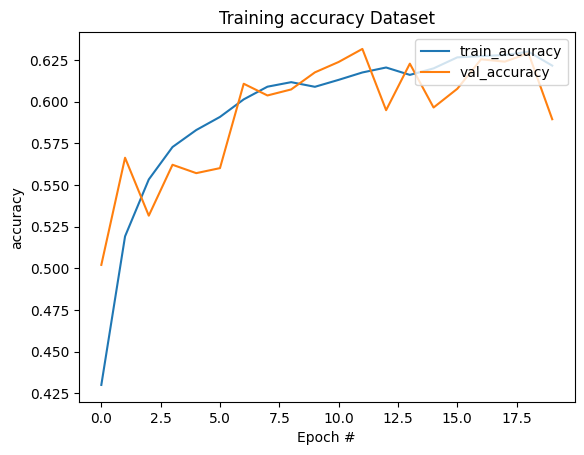

In [ ]:
plot_history(vgg16_history)

**Observations and Insights:**

**From this short test we can see a clear improvement that deserves to be further investigated. Both training and validation are improving consistently and show that it's promising.**

48x48 to 224x224 can introduce artifacts, modern interpolation methods (e.g., bilinear or bicubic) mitigate this to some extent.**

## **ResNet V2 Model**

In [ ]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten

In [ ]:
img_h, img_w = 224, 224
batches_size = 32

train_data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

basic_data_gen = ImageDataGenerator(rescale=1./255)
class_names = ['happy', 'neutral', 'sad', 'surprise']

train_generator = train_data_gen.flow_from_directory(
    '/content/Facial_emotion_images/train',
    target_size=(img_h, img_w),
    batch_size=batches_size,
    class_mode='categorical',
    shuffle=True,
)

val_generator = basic_data_gen.flow_from_directory(
    '/content/Facial_emotion_images/validation',
    target_size=(img_h, img_w),
    batch_size=batches_size,
    class_mode='categorical',
    shuffle=False,
)

test_generator = basic_data_gen.flow_from_directory(
    '/content/Facial_emotion_images/test',
    target_size=(img_h, img_w),
    batch_size=batches_size,
    class_mode='categorical',
    shuffle=False,
)

num_classes = len(train_generator.class_indices)
print(f"Number of classes detected: {num_classes}")

num_classes = 4

Found 15109 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.
Found 128 images belonging to 4 classes.
Number of classes detected: 4


In [ ]:
img_h, img_w = 224, 224
modelR = ResNet50V2(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))
modelR.summary()

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "resnet50v2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 23,519,360 (89.72 MB)

 Non-trainable params: 45,440 (177.50 KB)

### **Model Building**

- Import Resnet v2 upto the layer of your choice and add Fully Connected layers on top of it.

In [ ]:
transfer_layer = modelR.layers[-2].output
modelR = Model(inputs=modelR.input, outputs=transfer_layer)

In [ ]:
for layer in modelR.layers:
    layer.trainable = False

In [ ]:
for layer in modelR.layers:
    print(layer.name, layer.trainable)

input_layer_1 False
conv1_pad False
conv1_conv False
pool1_pad False
pool1_pool False
conv2_block1_preact_bn False
conv2_block1_preact_relu False
conv2_block1_1_conv False
conv2_block1_1_bn False
conv2_block1_1_relu False
conv2_block1_2_pad False
conv2_block1_2_conv False
conv2_block1_2_bn False
conv2_block1_2_relu False
conv2_block1_0_conv False
conv2_block1_3_conv False
conv2_block1_out False
conv2_block2_preact_bn False
conv2_block2_preact_relu False
conv2_block2_1_conv False
conv2_block2_1_bn False
conv2_block2_1_relu False
conv2_block2_2_pad False
conv2_block2_2_conv False
conv2_block2_2_bn False
conv2_block2_2_relu False
conv2_block2_3_conv False
conv2_block2_out False
conv2_block3_preact_bn False
conv2_block3_preact_relu False
conv2_block3_1_conv False
conv2_block3_1_bn False
conv2_block3_1_relu False
conv2_block3_2_pad False
conv2_block3_2_conv False
conv2_block3_2_bn False
conv2_block3_2_relu False
max_pooling2d False
conv2_block3_3_conv False
conv2_block3_out False
conv3_bloc

In [ ]:
from keras.layers import GlobalAveragePooling2D

x = modelR.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

resnet_model = Model(inputs=modelR.input, outputs=predictions)

In [ ]:
img_h, img_w = 224, 224
batches_size = 32

In [ ]:
resnet_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
resnet_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 24,746,244 (94.40 MB)

 Trainable params: 1,181,444 (4.51 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [ ]:
for layer in resnet_model.layers:
    print(layer.name, layer.trainable)

input_layer_1 False
conv1_pad False
conv1_conv False
pool1_pad False
pool1_pool False
conv2_block1_preact_bn False
conv2_block1_preact_relu False
conv2_block1_1_conv False
conv2_block1_1_bn False
conv2_block1_1_relu False
conv2_block1_2_pad False
conv2_block1_2_conv False
conv2_block1_2_bn False
conv2_block1_2_relu False
conv2_block1_0_conv False
conv2_block1_3_conv False
conv2_block1_out False
conv2_block2_preact_bn False
conv2_block2_preact_relu False
conv2_block2_1_conv False
conv2_block2_1_bn False
conv2_block2_1_relu False
conv2_block2_2_pad False
conv2_block2_2_conv False
conv2_block2_2_bn False
conv2_block2_2_relu False
conv2_block2_3_conv False
conv2_block2_out False
conv2_block3_preact_bn False
conv2_block3_preact_relu False
conv2_block3_1_conv False
conv2_block3_1_bn False
conv2_block3_1_relu False
conv2_block3_2_pad False
conv2_block3_2_conv False
conv2_block3_2_bn False
conv2_block3_2_relu False
max_pooling2d False
conv2_block3_3_conv False
conv2_block3_out False
conv3_bloc

In [ ]:
resnet_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
resnet_history = resnet_model.fit(train_generator, validation_data=val_generator, epochs=5, verbose=2)

Epoch 1/5
473/473 - 186s - 393ms/step - accuracy: 0.2955 - loss: 1.3893 - val_accuracy: 0.3978 - val_loss: 1.3278
Epoch 2/5
473/473 - 178s - 376ms/step - accuracy: 0.2963 - loss: 1.3548 - val_accuracy: 0.4107 - val_loss: 1.3076
Epoch 3/5
473/473 - 175s - 370ms/step - accuracy: 0.2906 - loss: 1.3580 - val_accuracy: 0.3769 - val_loss: 1.3490
Epoch 4/5
473/473 - 180s - 380ms/step - accuracy: 0.2919 - loss: 1.3560 - val_accuracy: 0.3072 - val_loss: 1.3083
Epoch 5/5
473/473 - 176s - 372ms/step - accuracy: 0.2988 - loss: 1.3507 - val_accuracy: 0.2439 - val_loss: 1.3509


### **Evaluating the ResNet Model**

In [ ]:
resnet_model.evaluate(val_generator)
resnet_model.evaluate(test_generator)

156/156 ━━━━━━━━━━━━━━━━━━━━ 41s 261ms/step - accuracy: 0.0790 - loss: 1.3186
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 233ms/step - accuracy: 0.1854 - loss: 1.3282


[1.3581385612487793, 0.296875]

In [ ]:
def plot_history(history):
    N = len(history.history["accuracy"])
    plt.figure()
    plt.plot(np.arange(0, N), history.history["accuracy"], label="train_accuracy")
    plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_accuracy")
    plt.title("Training accuracy Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("accuracy")
    plt.legend(loc="upper right")

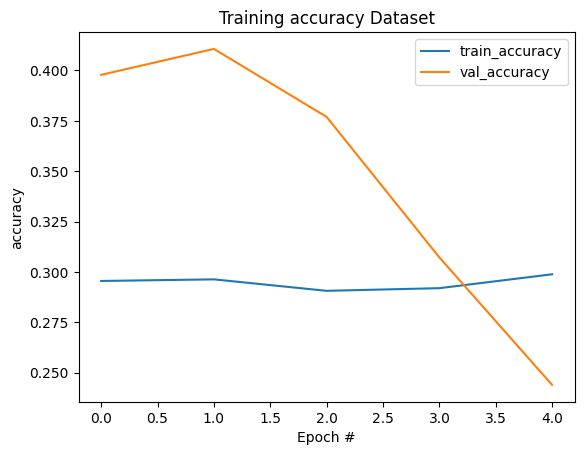

In [ ]:
plot_history(resnet_history)

**Observations and Insights:**

Overfitting and instability in the validation results. It may be necessary to test different architectures and sizes to find the optimal configuration.

Use early layers for basic feature extraction and focus on deeper layers (e.g., Block 5) for facial features.

The **Global Average Pooling (GAP)** layer is often used to produce a compact feature vector for recognition tasks.

## **EfficientNet Model**

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Flatten, Dense, GlobalAveragePooling2D

img_h, img_w = 224, 224

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))
base_model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_4[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 4,007,548 (15.29 MB)

 Non-trainable params: 42,023 (164.16 KB)

### **Model Building**

- Import EfficientNet upto the layer of your choice and add Fully Connected layers on top of it.

In [ ]:
for layer in base_model.layers:
    print(layer.name, layer.trainable)

input_layer_4 True
rescaling True
normalization True
rescaling_1 True
stem_conv_pad True
stem_conv True
stem_bn True
stem_activation True
block1a_dwconv True
block1a_bn True
block1a_activation True
block1a_se_squeeze True
block1a_se_reshape True
block1a_se_reduce True
block1a_se_expand True
block1a_se_excite True
block1a_project_conv True
block1a_project_bn True
block2a_expand_conv True
block2a_expand_bn True
block2a_expand_activation True
block2a_dwconv_pad True
block2a_dwconv True
block2a_bn True
block2a_activation True
block2a_se_squeeze True
block2a_se_reshape True
block2a_se_reduce True
block2a_se_expand True
block2a_se_excite True
block2a_project_conv True
block2a_project_bn True
block2b_expand_conv True
block2b_expand_bn True
block2b_expand_activation True
block2b_dwconv True
block2b_bn True
block2b_activation True
block2b_se_squeeze True
block2b_se_reshape True
block2b_se_reduce True
block2b_se_expand True
block2b_se_excite True
block2b_project_conv True
block2b_project_bn True

In [ ]:
new_model = Sequential()

new_model.add(base_model)
new_model.add(GlobalAveragePooling2D())
new_model.add(Flatten())
new_model.add(Dense(32, activation='relu'))
new_model.add(Dense(32, activation='relu'))
new_model.add(Dense(4, activation='softmax'))

### **Compiling and Training the Model**

In [ ]:
new_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
new_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 32)             │        40,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,091,751 (15.61 MB)

 Trainable params: 4,049,728 (15.45 MB)

 Non-trainable params: 42,023 (164.16 KB)

### **Evaluating the EfficientnetNet Model**

In [ ]:
efficientnet_history = new_model.fit(train_generator, validation_data=val_generator, epochs=20, verbose=2)

Epoch 1/5
473/473 - 328s - 693ms/step - accuracy: 0.6390 - loss: 0.8650 - val_accuracy: 0.2323 - val_loss: 1.5432
Epoch 2/5
473/473 - 196s - 414ms/step - accuracy: 0.7165 - loss: 0.6943 - val_accuracy: 0.2289 - val_loss: 1.6365
Epoch 3/5
473/473 - 195s - 411ms/step - accuracy: 0.7466 - loss: 0.6336 - val_accuracy: 0.2289 - val_loss: 1.4342
Epoch 4/5
473/473 - 197s - 415ms/step - accuracy: 0.7572 - loss: 0.5984 - val_accuracy: 0.2289 - val_loss: 1.9161
Epoch 5/5
473/473 - 194s - 410ms/step - accuracy: 0.7703 - loss: 0.5741 - val_accuracy: 0.1605 - val_loss: 1.9668


In [ ]:
new_model.evaluate(val_generator)
new_model.evaluate(test_generator)

156/156 ━━━━━━━━━━━━━━━━━━━━ 28s 177ms/step - accuracy: 0.6407 - loss: 0.8721
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - accuracy: 0.6427 - loss: 0.8414


[0.8066143989562988, 0.65625]

In [ ]:
def plot_history(history):
    N = len(history.history["accuracy"])
    plt.figure()
    plt.plot(np.arange(0, N), history.history["accuracy"], label="train_accuracy")
    plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_accuracy")
    plt.title("Training accuracy Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("accuracy")
    plt.legend(loc="upper right")

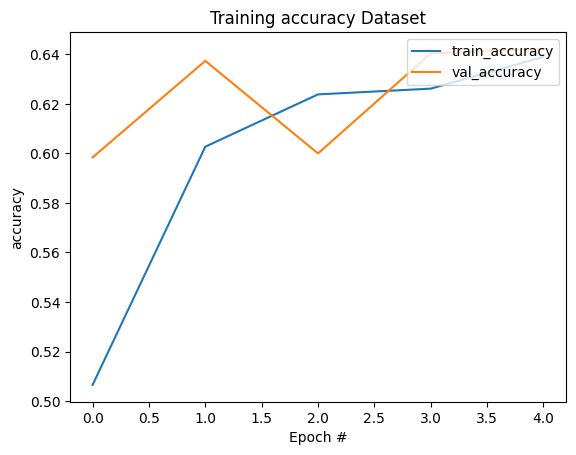

In [ ]:
plot_history(efficientnet_history)

**Observations and Insights:**

**Good performance.**

**Accuracy near to 77% and stable.**

Now that we have tried multiple pre-trained models, let's build a complex CNN architecture and see if we can get better performance.

## **Building a Complex Neural Network Architecture**

In this section, we will build a more complex Convolutional Neural Network Model that has close to as many parameters as we had in our Transfer Learning Models. However, we will have only 1 input channel for our input images.

## **Creating our Data Loaders**

In this section, we are creating data loaders which we will use as inputs to the more Complicated Convolutional Neural Network. We will go ahead with color_mode = 'grayscale'.

In [ ]:
img_h, img_w = 48, 48
batches_size = 32

train_data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

basic_data_gen = ImageDataGenerator(rescale=1./255)
class_names = ['happy', 'neutral', 'sad', 'surprise']

train_generator = train_data_gen.flow_from_directory(
    '/content/Facial_emotion_images/train',
    target_size=(img_h, img_w),
    batch_size=batches_size,
    class_mode='categorical',
    shuffle=True,
)

val_generator = basic_data_gen.flow_from_directory(
    '/content/Facial_emotion_images/validation',
    target_size=(img_h, img_w),
    batch_size=batches_size,
    class_mode='categorical',
    shuffle=False,
)

test_generator = basic_data_gen.flow_from_directory(
    '/content/Facial_emotion_images/test',
    target_size=(img_h, img_w),
    batch_size=batches_size,
    class_mode='categorical',
    shuffle=False,
)

num_classes = len(train_generator.class_indices)
print(f"Number of classes detected: {num_classes}")

num_classes = 4

Found 15109 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.
Found 128 images belonging to 4 classes.
Number of classes detected: 4


### **Model Building**

- Try building a layer with 5 Convolutional Blocks and see if performance increases.

In [ ]:
cnn_model_complex = Sequential()

cnn_model_complex.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 3), padding='same'))
cnn_model_complex.add(BatchNormalization())
cnn_model_complex.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model_complex.add(Dropout(0.25))

cnn_model_complex.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
cnn_model_complex.add(BatchNormalization())
cnn_model_complex.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model_complex.add(Dropout(0.25))

cnn_model_complex.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
cnn_model_complex.add(BatchNormalization())
cnn_model_complex.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model_complex.add(Dropout(0.25))

cnn_model_complex.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
cnn_model_complex.add(BatchNormalization())
cnn_model_complex.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model_complex.add(Dropout(0.25))

cnn_model_complex.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
cnn_model_complex.add(BatchNormalization())
cnn_model_complex.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model_complex.add(Dropout(0.25))


cnn_model_complex.add(Flatten())
cnn_model_complex.add(Dense(512, activation='relu'))
cnn_model_complex.add(BatchNormalization())
cnn_model_complex.add(Dropout(0.5))
cnn_model_complex.add(Dense(4, activation='softmax'))

### **Compiling and Training the Model**

In [ ]:
cnn_model_complex.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
cnn_model_complex.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_33 (Conv2D)                   │ (None, 48, 48, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 48, 48, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_33 (MaxPooling2D)      │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_34 (MaxPooling2D)      │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_35 (MaxPooling2D)      │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_36 (Conv2D)                   │ (None, 6, 6, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 6, 6, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_36 (MaxPooling2D)      │ (None, 3, 3, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 3, 3, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 3, 3, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 3, 3, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_37 (MaxPooling2D)      │ (None, 1, 1, 512)           │              

 Total params: 1,839,300 (7.02 MB)

 Trainable params: 1,836,292 (7.00 MB)

 Non-trainable params: 3,008 (11.75 KB)

In [ ]:
cnn_history_complex = cnn_model_complex.fit(train_generator, epochs=20, validation_data=val_generator, verbose=2)

Epoch 1/20
473/473 - 211s - 445ms/step - accuracy: 0.3119 - loss: 1.6489 - val_accuracy: 0.2684 - val_loss: 1.7732
Epoch 2/20
473/473 - 216s - 458ms/step - accuracy: 0.4031 - loss: 1.3155 - val_accuracy: 0.4925 - val_loss: 1.1540
Epoch 3/20
473/473 - 248s - 523ms/step - accuracy: 0.4642 - loss: 1.1890 - val_accuracy: 0.4412 - val_loss: 1.2171
Epoch 4/20
473/473 - 237s - 502ms/step - accuracy: 0.5133 - loss: 1.1059 - val_accuracy: 0.6199 - val_loss: 0.9231
Epoch 5/20
473/473 - 194s - 409ms/step - accuracy: 0.5485 - loss: 1.0375 - val_accuracy: 0.5519 - val_loss: 1.0643
Epoch 6/20
473/473 - 209s - 442ms/step - accuracy: 0.5660 - loss: 1.0044 - val_accuracy: 0.6560 - val_loss: 0.8222
Epoch 7/20
473/473 - 197s - 417ms/step - accuracy: 0.5838 - loss: 0.9742 - val_accuracy: 0.6685 - val_loss: 0.8007
Epoch 8/20
473/473 - 193s - 407ms/step - accuracy: 0.5943 - loss: 0.9477 - val_accuracy: 0.6420 - val_loss: 0.8887
Epoch 9/20
473/473 - 213s - 450ms/step - accuracy: 0.6024 - loss: 0.9321 - val_a

### **Evaluating the Model on Test Set**

In [ ]:
cnn_model_complex.evaluate(val_generator)
cnn_model_complex.evaluate(test_generator)

156/156 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step - accuracy: 0.7916 - loss: 0.5422
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7510 - loss: 0.6590


[0.6812055706977844, 0.7265625]

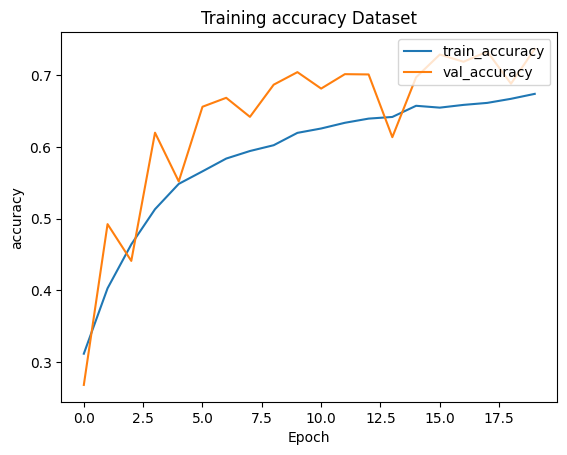

In [ ]:
def plot_history(history):
    N = len(history.history["accuracy"])
    plt.figure()
    plt.plot(np.arange(0, N), history.history["accuracy"], label="train_accuracy")
    plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_accuracy")
    plt.title("Training accuracy Dataset")
    plt.xlabel("Epoch")
    plt.ylabel("accuracy")
    plt.legend(loc="upper right")

plot_history(cnn_history_complex)

**Observations and Insights:**

67% accuracy on the training test, val_accuracy: 73% and 75% on the test.

### **Plotting the Confusion Matrix for the chosen final model**

4/4 - 2s - 455ms/step - accuracy: 0.7266 - loss: 0.6812
CNN Test Accuracy:  0.7266
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


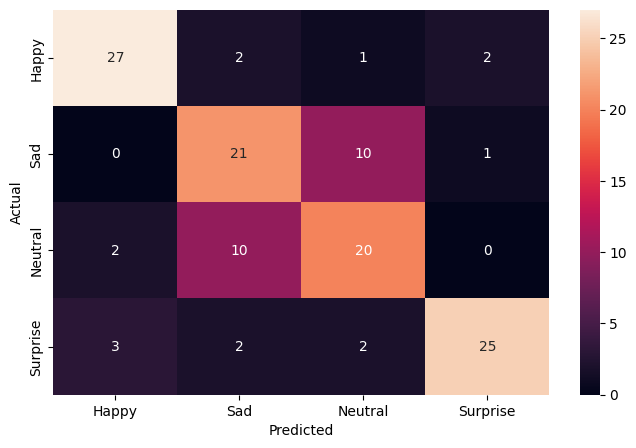

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

cnn_loss, cnn_accuracy = cnn_model_complex.evaluate(test_generator, verbose=2)
print(f"CNN Test Accuracy: {cnn_accuracy: .4f}")

pred = cnn_model_complex.predict(test_generator)
pred = np.argmax(pred, axis = 1)

y_true = test_generator.classes

cm = confusion_matrix(y_true, pred)
plt.figure(figsize = (8, 5))
sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['Happy', 'Sad', 'Neutral', 'Surprise'], yticklabels = ['Happy', 'Sad', 'Neutral', 'Surprise'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Observations and Insights**

Needs improvement (tuning)

Potential but time-consuming

## **Conclusion:**
**We tested 1 ANN, 3 CNN, 3 transfer learning models and one complex CNN.**

Summary:

(20 epochs)

**ANN**  accuracy: 0.4233  val_accuracy: 0.46177 test:accuracy: 0.5490

**CNN1** accuracy: 0.6943  val_accuracy: 0.6710  test:accuracy: 0.7604

**CNN2 accuracy: 0.7505  val_accuracy: 0.7372  test:accuracy: 0.7812**

**CNN3** accuracy: 0.6329  val_accuracy: 0.7812  test:accuracy: 0.0860

**VGG16** model accuracy: 0.6380 val_loss: 0.8290 test:accuracy: 0.6865

**ResNet V2** w/ GAP accuracy: 0.5424  val_accuracy: 0.5843 test:accuracy: 0.5552

**EfficientNet w/ GAP accuracy: 0.7703 val_accuracy: 0.1605 test:accuracy: 0.6427 => Best potential but Overfit**

**Complex CNN** accuracy: 0.6740   val_accuracy: 0.7366 test:accuracy: 0.7510


**CNNs are better than ANNs for facial recognition** because they automatically extract spatial features (such as edges, textures, and shapes) from images using convolutional layers, making them more accurate and efficient for image-based tasks.

**CNNs** help reduce size issues through convolution and pooling, which extract important features. This makes them more efficient and scalable for handling varying input sizes, unlike ANNs, which require fixed-size, flattened inputs and can struggle with large images. However, CNNs still require tuning.

**VGG16**: Easy to understand, provides good performance, but is very large and slow.

**ResNet**: A deep network with skip connections (to avoid vanishing gradients), offering better performance than VGG, but still quite heavy.

**EfficientNet**: Offers the best accuracy-to-size trade-off and is highly optimized, though more complex to implement.

Overfit. Needs improvement. I' ll work more on it.

**Our Complex_CNN**: Used for learning and experimentation. It has limited data and resources but offers full control over the architecture.
